In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoModel, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from collections import defaultdict
import torch
import os
import logging
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from textwrap import wrap
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

RANDOM_SEED = 42

In [3]:
from transformers import Adafactor

In [4]:
#!pip install https://github.com/kpu/kenlm/archive/master.zip

In [5]:
#!wget https://thunlp.oss-cn-qingdao.aliyuncs.com/BERT_CCPoem_v1.zip

In [6]:
#!unzip BERT_CCPoem_v1.zip

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
senti_all = pd.read_csv("/content/drive/MyDrive/senti_all.csv")
senti_all.head()

,poet,poem,dynasty,sentiments,title
0,王寂,吾爱吾庐事事幽|此生随分得优游|穷冬夜话蒲团暖|长夏朝眠竹簟秋,金,"{'holistic': '3', 'line1': '3', 'line2': '3', ...",易足斋
1,王安石,淮圃新阴百亩凉|分甘每得助秋尝|张公大谷虽云美|谁肯苞苴出晋阳,宋,"{'holistic': '3', 'line1': '3', 'line2': '3', ...",耿天騭惠梨次韵奉酬三首
2,陆游,白发无情日日生|散愁聊复作山行|幽禽似欲嘲衰病|故学禅房杵药声,宋,"{'holistic': '2', 'line1': '2', 'line2': '2', ...",捣药鸟
3,王绂,堂前慈竹翠婆娑|堂上慈亲鬓已皤|歴尽氷霜当雨露|诸縁应见锦绷多,明,"{'holistic': '3', 'line1': '4', 'line2': '2', ...",写竹于慈节堂巻
4,刘克庄,津吏难绳束|滩船易覆翻|能除一方害|不忝二刘孙,宋,"{'holistic': '3', 'line1': '3', 'line2': '2', ...",送勋侄之官嵢峡五言五首


In [9]:
scoreone =  senti_all[senti_all["sentiments"].str.contains("'holistic': '1'")]
scoretwo =  senti_all[senti_all["sentiments"].str.contains("'holistic': '2'")]
scorethree = senti_all[senti_all["sentiments"].str.contains("'holistic': '3'")]
scorefour =  senti_all[senti_all["sentiments"].str.contains("'holistic': '4'")]
scorefive =  senti_all[senti_all["sentiments"].str.contains("'holistic': '5'")]
scoreone.head(2)

,poet,poem,dynasty,sentiments,title
11,朱淑真,起来不喜匀红粉|强把菱花照病容|腰瘦故知闲事恼|泪多只为别情浓,宋,"{'holistic': '1', 'line1': '3', 'line2': '2', ...",睡起二首
17,王夫之,枯木难消只赋心|散愁长欲寄知音|调孤雌霓休文句|哭碎灵床子敬琴,明,"{'holistic': '1', 'line1': '2', 'line2': '1', ...",哭欧阳三弟叔敬沈湘六首


In [10]:
pd.set_option('mode.chained_assignment',  None)
scoreone['sentiments'] = scoreone['sentiments'].map('0'.format)
scoretwo['sentiments'] = scoretwo['sentiments'].map('0'.format)
scorethree['sentiments'] = scorethree['sentiments'].map('1'.format)
scorefour['sentiments'] = scorefour['sentiments'].map('2'.format)
scorefive['sentiments'] = scorefive['sentiments'].map('2'.format)
senti_all = pd.concat([scoreone, scoretwo, scorethree, scorefour, scorefive])

senti_all.head(2)

,poet,poem,dynasty,sentiments,title
11,朱淑真,起来不喜匀红粉|强把菱花照病容|腰瘦故知闲事恼|泪多只为别情浓,宋,0,睡起二首
17,王夫之,枯木难消只赋心|散愁长欲寄知音|调孤雌霓休文句|哭碎灵床子敬琴,明,0,哭欧阳三弟叔敬沈湘六首


In [11]:
senti_all = senti_all.sample(frac=1).reset_index(drop=True)
senti_all.head(2)

,poet,poem,dynasty,sentiments,title
0,元好问,燕语莺啼百啭新|长廊寂寂不逢人|东君去作谁家客|花柳无情各自春,元,0,杂著二首
1,夏竦,浴兰袭祉良辰启|握纪无为圣道尊|舄奕嘉祥充九禁|冲融和气徧干门,宋,2,御阁端午帖子


In [12]:
count = pd.value_counts(senti_all['sentiments'])
count

2    1917
0    1755
1    1328
Name: sentiments, dtype: int64

In [13]:
senti_all["poem"] = senti_all["poem"].str.replace(pat=r'[|]', repl=r'', regex=True)
senti_all.head()

,poet,poem,dynasty,sentiments,title
0,元好问,燕语莺啼百啭新长廊寂寂不逢人东君去作谁家客花柳无情各自春,元,0,杂著二首
1,夏竦,浴兰袭祉良辰启握纪无为圣道尊舄奕嘉祥充九禁冲融和气徧干门,宋,2,御阁端午帖子
2,司马光,灵台无事日休休安乐由来不外求细雨寒风宜独坐暖天佳景即闲游,宋,2,和邵尧夫安乐窝中职事吟
3,宋祁,七里城南路斋祠宿下房远烟晨燎地斜日夕牲场,宋,2,南郊祠所上章摄事二首
4,葛胜仲,味佳端可供羮梜韵胜尤宜荐酒螺自笑痴人饕口腹不求新竹透林多,宋,2,烹笋


In [14]:
# 전처리 조절
def text_process(text):
    words = list(text)    
    return words

In [15]:
senti_all['tokens'] = senti_all['poem'].apply(text_process)
senti_all.head(2)

,poet,poem,dynasty,sentiments,title,tokens
0,元好问,燕语莺啼百啭新长廊寂寂不逢人东君去作谁家客花柳无情各自春,元,0,杂著二首,"[燕, 语, 莺, 啼, 百, 啭, 新, 长, 廊, 寂, 寂, 不, 逢, 人, 东, ..."
1,夏竦,浴兰袭祉良辰启握纪无为圣道尊舄奕嘉祥充九禁冲融和气徧干门,宋,2,御阁端午帖子,"[浴, 兰, 袭, 祉, 良, 辰, 启, 握, 纪, 无, 为, 圣, 道, 尊, 舄, ..."


In [16]:
senti_all['final_tokens'] = [''.join(map(str, l)) for l in senti_all['tokens']] #''사이를 붙임.
senti_all.head(2)

,poet,poem,dynasty,sentiments,title,tokens,final_tokens
0,元好问,燕语莺啼百啭新长廊寂寂不逢人东君去作谁家客花柳无情各自春,元,0,杂著二首,"[燕, 语, 莺, 啼, 百, 啭, 新, 长, 廊, 寂, 寂, 不, 逢, 人, 东, ...",燕语莺啼百啭新长廊寂寂不逢人东君去作谁家客花柳无情各自春
1,夏竦,浴兰袭祉良辰启握纪无为圣道尊舄奕嘉祥充九禁冲融和气徧干门,宋,2,御阁端午帖子,"[浴, 兰, 袭, 祉, 良, 辰, 启, 握, 纪, 无, 为, 圣, 道, 尊, 舄, ...",浴兰袭祉良辰启握纪无为圣道尊舄奕嘉祥充九禁冲融和气徧干门


In [17]:
senti_all["Length"]=senti_all["poem"].apply(len)
senti_all.head(3)

,poet,poem,dynasty,sentiments,title,tokens,final_tokens,Length
0,元好问,燕语莺啼百啭新长廊寂寂不逢人东君去作谁家客花柳无情各自春,元,0,杂著二首,"[燕, 语, 莺, 啼, 百, 啭, 新, 长, 廊, 寂, 寂, 不, 逢, 人, 东, ...",燕语莺啼百啭新长廊寂寂不逢人东君去作谁家客花柳无情各自春,28
1,夏竦,浴兰袭祉良辰启握纪无为圣道尊舄奕嘉祥充九禁冲融和气徧干门,宋,2,御阁端午帖子,"[浴, 兰, 袭, 祉, 良, 辰, 启, 握, 纪, 无, 为, 圣, 道, 尊, 舄, ...",浴兰袭祉良辰启握纪无为圣道尊舄奕嘉祥充九禁冲融和气徧干门,28
2,司马光,灵台无事日休休安乐由来不外求细雨寒风宜独坐暖天佳景即闲游,宋,2,和邵尧夫安乐窝中职事吟,"[灵, 台, 无, 事, 日, 休, 休, 安, 乐, 由, 来, 不, 外, 求, 细, ...",灵台无事日休休安乐由来不外求细雨寒风宜独坐暖天佳景即闲游,28


In [18]:
df = senti_all
df.head(2)

,poet,poem,dynasty,sentiments,title,tokens,final_tokens,Length
0,元好问,燕语莺啼百啭新长廊寂寂不逢人东君去作谁家客花柳无情各自春,元,0,杂著二首,"[燕, 语, 莺, 啼, 百, 啭, 新, 长, 廊, 寂, 寂, 不, 逢, 人, 东, ...",燕语莺啼百啭新长廊寂寂不逢人东君去作谁家客花柳无情各自春,28
1,夏竦,浴兰袭祉良辰启握纪无为圣道尊舄奕嘉祥充九禁冲融和气徧干门,宋,2,御阁端午帖子,"[浴, 兰, 袭, 祉, 良, 辰, 启, 握, 纪, 无, 为, 圣, 道, 尊, 舄, ...",浴兰袭祉良辰启握纪无为圣道尊舄奕嘉祥充九禁冲融和气徧干门,28


In [19]:
df = df.astype({'sentiments': 'int'})

In [20]:
BATCH_SIZE = 16
model_name = "hfl/chinese-roberta-wwm-ext"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [21]:
sample_txt = '吾爱吾庐事事幽，此生随分得优 游穷冬夜话蒲团。暖长夏朝眠竹簟秋.'

In [22]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: 吾爱吾庐事事幽，此生随分得优 游穷冬夜话蒲团。暖长夏朝眠竹簟秋.
   Tokens: ['吾', '爱', '吾', '庐', '事', '事', '幽', '，', '此', '生', '随', '分', '得', '优', '游', '穷', '冬', '夜', '话', '蒲', '团', '。', '暖', '长', '夏', '朝', '眠', '竹', '[UNK]', '秋', '.']
Token IDs: [1434, 4263, 1434, 2416, 752, 752, 2406, 8024, 3634, 4495, 7390, 1146, 2533, 831, 3952, 4956, 1100, 1915, 6413, 5891, 1730, 511, 3265, 7270, 1909, 3308, 4697, 5001, 100, 4904, 119]


In [23]:
tokenizer.sep_token, tokenizer.sep_token_id   # 토큰 번호 확인 

('[SEP]', 102)

In [24]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [25]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [26]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [27]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=128,
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [28]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

128


tensor([ 101, 1434, 4263, 1434, 2416,  752,  752, 2406, 8024, 3634, 4495, 7390,
        1146, 2533,  831, 3952, 4956, 1100, 1915, 6413, 5891, 1730,  511, 3265,
        7270, 1909, 3308, 4697, 5001,  100, 4904,  119,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [29]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

128


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [30]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 '吾',
 '爱',
 '吾',
 '庐',
 '事',
 '事',
 '幽',
 '，',
 '此',
 '生',
 '随',
 '分',
 '得',
 '优',
 '游',
 '穷',
 '冬',
 '夜',
 '话',
 '蒲',
 '团',
 '。',
 '暖',
 '长',
 '夏',
 '朝',
 '眠',
 '竹',
 '[UNK]',
 '秋',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',


In [31]:
token_lens = []
for txt in df.final_tokens:
    tokens = tokenizer.encode(txt, max_length=128)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


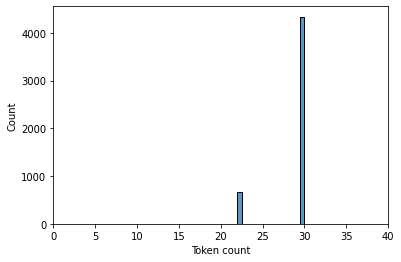

In [32]:
sns.histplot(token_lens)
plt.xlim([0, 40]);
plt.xlabel('Token count')
plt.show();

In [33]:
import random
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [34]:
MAX_LEN = 128

In [35]:
class GPReviewDataset(Dataset):
    
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self, item):
        review = str(self.review[item])

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation = True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(self.target[item], dtype=torch.long)
        }

In [36]:
df_train, df_val = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)

In [37]:
df_train.shape, df_val.shape,# df_test.shape

((4500, 8), (500, 8))

In [38]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
      review=df.final_tokens.to_numpy(),
      target=df.sentiments.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
    )
    return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
    )

In [39]:
BATCH_SIZE = BATCH_SIZE
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
#test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [40]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [41]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


In [42]:
bert_model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'], 
    attention_mask=encoding['attention_mask'],
    return_dict = False 
    #we can pass an additional kwarg return_dict = False 
    #when we call the bert_model() to get an actual tensor that 
    #corresponds to the last_hidden_state
)

In [44]:
last_hidden_state.shape

torch.Size([1, 128, 768])

In [45]:
pooled_output.shape

torch.Size([1, 768])

In [46]:
bert_model.config.hidden_size

768

In [47]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
class_names = ['negative', 'neutral', 'positive']

In [50]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [52]:
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 128])
torch.Size([16, 128])


In [53]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4049, 0.1948, 0.4003],
        [0.2624, 0.4579, 0.2796],
        [0.2886, 0.4439, 0.2675],
        [0.4452, 0.4400, 0.1148],
        [0.6136, 0.2857, 0.1008],
        [0.3339, 0.4292, 0.2369],
        [0.3180, 0.3735, 0.3085],
        [0.5438, 0.3571, 0.0991],
        [0.3285, 0.4488, 0.2227],
        [0.3627, 0.3410, 0.2963],
        [0.4688, 0.3544, 0.1768],
        [0.4829, 0.2529, 0.2642],
        [0.5884, 0.2763, 0.1353],
        [0.6413, 0.2595, 0.0993],
        [0.5495, 0.2535, 0.1970],
        [0.4271, 0.3155, 0.2573]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [54]:
from sklearn.model_selection import GridSearchCV

grid_values = {'lr': [1e-4, 1e-5, 1e-6, 2e-5, 3e-3],
               'eps': [1e-7, 1e-8, 1e-9, 1e-10, 1e-11],
               'EPOCHS' : [1,2]
              }

In [55]:
EPOCHS = 1
optimizer = AdamW(model.parameters(), lr=1e-5, 
                  correct_bias=False, eps=1e-7)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [56]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples,
    accumulation_steps=1, # 이 부분 숫자 변경. 기본 batch size가 8이라면 accumulation_steps를 4로 바꿔주면 batch size가 32가 되는 것과 같음.
):
    model = model.train()
        
    losses = []
    correct_predictions = 0
    optimizer.zero_grad()

    for i, (d) in enumerate(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss = loss / accumulation_steps 
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        if (i+1) % accumulation_steps == 0:
          optimizer.step()
          scheduler.step()
          optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [57]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
        return correct_predictions.double() / n_examples, np.mean(losses)

In [58]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc   # val loss가 늘어나기 시작하면 오버피팅 발생. 그래서 val acc가 떨어짐. Train loss는 원래 특정 값까지는 계속 떨어짐.

Epoch 1/1
----------
Train loss 0.8331527946688605 accuracy 0.6168888888888889
Val   loss 0.6941744554787874 accuracy 0.728

CPU times: user 1min 4s, sys: 24.8 s, total: 1min 29s
Wall time: 1min 37s


# 나의 데이터에 적용

In [59]:
test = pd.read_csv("/content/drive/MyDrive/mydata6.csv")
test.head(1)

,number,place,send,odate,rdate,types,ow,ot,oc,rw1,...,rc5,rw6,rt6,rc6,rw7,rt7,rc7,rw8,rt8,rc8
0,1.0,개봉,NaN,1059.0,NaN,1.0,蘇轍,山胡,山胡拥苍毳，两耳白茸茸。野树啼终日，黔山深几重。啄溪探细石，噪虎上孤峰。被执应多恨，筠笼仅不容。,蘇軾,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
test_oc = test[["oc"]].dropna(axis=0)
test_rc1 = test[["rc1"]].dropna(axis=0)
test_rc2 = test[["rc2"]].dropna(axis=0)
test_rc3 = test[["rc3"]].dropna(axis=0)
test_rc4 = test[["rc4"]].dropna(axis=0)
test_rc5 = test[["rc5"]].dropna(axis=0)
test_rc6 = test[["rc6"]].dropna(axis=0)
test_rc7 = test[["rc7"]].dropna(axis=0)
test_rc8 = test[["rc8"]].dropna(axis=0)

In [61]:
test_oc.columns = ['contents']
test_rc1.columns = ['contents']
test_rc2.columns = ['contents']
test_rc3.columns = ['contents']
test_rc4.columns = ['contents']
test_rc5.columns = ['contents']
test_rc6.columns = ['contents']
test_rc7.columns = ['contents']
test_rc8.columns = ['contents']

In [62]:
test = pd.concat([test_oc, test_rc1, test_rc2,test_rc3, test_rc4,
                   test_rc5, test_rc6, test_rc7, test_rc8], ignore_index = True)
test.columns = ['poem']
test["sentiments"] = ""
test.head(1)

,poem,sentiments
0,山胡拥苍毳，两耳白茸茸。野树啼终日，黔山深几重。啄溪探细石，噪虎上孤峰。被执应多恨，筠笼仅不容。,


In [63]:
test["final_tokens"] = test["poem"].str.replace(pat=r'[，。]', repl=r'', regex=True)
test.head(3)

,poem,sentiments,final_tokens
0,山胡拥苍毳，两耳白茸茸。野树啼终日，黔山深几重。啄溪探细石，噪虎上孤峰。被执应多恨，筠笼仅不容。,,山胡拥苍毳两耳白茸茸野树啼终日黔山深几重啄溪探细石噪虎上孤峰被执应多恨筠笼仅不容
1,水官骑苍龙，龙行欲上天。手攀时且住，浩若乘风船。不知几何长，足尾犹在渊。下有二从臣，左右乘鱼...,,水官骑苍龙龙行欲上天手攀时且住浩若乘风船不知几何长足尾犹在渊下有二从臣左右乘鱼鼋矍铄相顾视风...
2,相携话别郑原上，共道长途怕雪泥。归骑还寻大梁陌，行人已渡古崤西。曾为县吏民知否，旧宿僧房壁共...,,相携话别郑原上共道长途怕雪泥归骑还寻大梁陌行人已渡古崤西曾为县吏民知否旧宿僧房壁共题遥想独游...


In [64]:
review_text1 = "山胡拥苍毳两耳白茸茸野树啼终日黔山深几重啄溪探细石噪虎上孤峰被执应多恨筠笼仅不容"

encoded_review = tokenizer.encode_plus(
  review_text1,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'text: {review_text1}')
print(f'Sentiment  : {class_names[prediction]}')

review_text2 = "终日锁筠笼回头惜翠茸谁知声㗲㗲亦自意重重夜宿烟生浦朝鸣日上峰故巢何足恋鹰隼岂能容"

encoded_review = tokenizer.encode_plus(
  review_text2,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'text: {review_text2}')
print(f'Sentiment  : {class_names[prediction]}')

text: 山胡拥苍毳两耳白茸茸野树啼终日黔山深几重啄溪探细石噪虎上孤峰被执应多恨筠笼仅不容
Sentiment  : negative
text: 终日锁筠笼回头惜翠茸谁知声㗲㗲亦自意重重夜宿烟生浦朝鸣日上峰故巢何足恋鹰隼岂能容
Sentiment  : negative


In [65]:
def predict_class(text):
  encoded_review = tokenizer.encode_plus(
    text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  return prediction

In [66]:
predicts = []

for i in range(len(test)):
    max_preds = predict_class(test["final_tokens"][i])
    predicts.append(int(max_preds))

In [67]:
len(predicts)

1008

In [68]:
input_predictions = pd.DataFrame(predicts) # 예측한 토픽을 데이터프레임으로 만들어 붙이기
input_predictions.columns = ["sentiments"]
test["sentiments"] = input_predictions["sentiments"] # 정답으로 가정하고 데이터프레임에 붙여넣기
test

,poem,sentiments,final_tokens
0,山胡拥苍毳，两耳白茸茸。野树啼终日，黔山深几重。啄溪探细石，噪虎上孤峰。被执应多恨，筠笼仅不容。,0,山胡拥苍毳两耳白茸茸野树啼终日黔山深几重啄溪探细石噪虎上孤峰被执应多恨筠笼仅不容
1,水官骑苍龙，龙行欲上天。手攀时且住，浩若乘风船。不知几何长，足尾犹在渊。下有二从臣，左右乘鱼...,1,水官骑苍龙龙行欲上天手攀时且住浩若乘风船不知几何长足尾犹在渊下有二从臣左右乘鱼鼋矍铄相顾视风...
2,相携话别郑原上，共道长途怕雪泥。归骑还寻大梁陌，行人已渡古崤西。曾为县吏民知否，旧宿僧房壁共...,0,相携话别郑原上共道长途怕雪泥归骑还寻大梁陌行人已渡古崤西曾为县吏民知否旧宿僧房壁共题遥想独游...
3,朝廷入忘返，山林往不还。念无高世姿，聊处可否间。筑基仿崔巍，鞭石轻险艰。群玉相磊落，万峰正孱...,0,朝廷入忘返山林往不还念无高世姿聊处可否间筑基仿崔巍鞭石轻险艰群玉相磊落万峰正孱颜种树亦苍苍激...
4,一岁不复居，一日安足惜。人心畏增年，对酒语终夕。夜长书室幽，灯烛明照席。盘飧杂梁楚，羊炙错鱼...,1,一岁不复居一日安足惜人心畏增年对酒语终夕夜长书室幽灯烛明照席盘飧杂梁楚羊炙错鱼腊庖人馔鸡兔家...
...,...,...,...
1003,雪堂蜜酒花作醅，教蜂使酿花自栽。堂前雪落蜂正蛰，恨蜂不采西山梅。漫浪饮处空有迹，无酒可沃胸崔...,1,雪堂蜜酒花作醅教蜂使酿花自栽堂前雪落蜂正蛰恨蜂不采西山梅漫浪饮处空有迹无酒可沃胸崔嵬不知几唤...
1004,于阗花骢龙八尺，看云不受络头丝。西河骢作蒲萄锦，双瞳夹镜耳卓锥。长楸落日试天步，知有四极无由...,1,于阗花骢龙八尺看云不受络头丝西河骢作蒲萄锦双瞳夹镜耳卓锥长楸落日试天步知有四极无由驰电行山立...
1005,风从落帆休，天与大江平。僧坊昼亦静，钟磬寒逾清。淹留属暇日，植杖数连甍。颇与幽子逢，煮茗当酒...,2,风从落帆休天与大江平僧坊昼亦静钟磬寒逾清淹留属暇日植杖数连甍颇与幽子逢煮茗当酒倾携手霜木末朱...
1006,朱颜发过如春醅，胸中梨枣初未栽。丹砂未易扫白发，赤松却欲参黄梅。寒溪本自远公社，白莲翠竹依崔...,1,朱颜发过如春醅胸中梨枣初未栽丹砂未易扫白发赤松却欲参黄梅寒溪本自远公社白莲翠竹依崔嵬当时石泉...


In [69]:
test["sentiments"].value_counts()

1    412
0    298
2    298
Name: sentiments, dtype: int64

In [70]:
test.to_csv("bert-base.csv")